### Problème pour les prints et les input sous VSCode, il faut ouvrir le notebook avec jupyter directement (dès fois ça marche quand même sous VS Code)

> Problème réglé en mettant des time.sleep(0.5) après les input pour laisser le temps d'afficher

In [31]:
import mdp
import pickle
import time

In [32]:
! python mdp.py < ex.mdp
# ! python mdp.py < chaine_1.mdp
# ! python mdp.py < ex_erreur.mdp

States: ['S0', 'S1', 'S2']
Actions: ['a', 'b']
Transition from S0 with no action and targets ['S1', 'S2'] with weights [5, 5]
Transition from S1 with action b and targets ['S1', 'S0'] with weights [2, 8]
Transition from S1 with action a and targets ['S2', 'S0', 'S1'] with weights [1, 3, 6]
Transition from S2 with action c and targets ['S0', 'S1'] with weights [5, 5]
{'States': ['S0', 'S1', 'S2'], 'Actions': ['a', 'b'], 'Transitions_with_action': {1: {'from': 'S1', 'action': 'b', 'targets': ['S1', 'S0'], 'weights': [2, 8]}, 2: {'from': 'S1', 'action': 'a', 'targets': ['S2', 'S0', 'S1'], 'weights': [1, 3, 6]}, 3: {'from': 'S2', 'action': 'c', 'targets': ['S0', 'S1'], 'weights': [5, 5]}}, 'Transitions_without_action': {0: {'from': 'S0', 'targets': ['S1', 'S2'], 'weights': [5, 5]}}}


In [33]:
# On lit le .pickle des données que l'on souhaitent récupérer

# Read list to memory
def read_list(nom_liste):
    # for reading also binary mode is important
    with open(nom_liste, 'rb') as fp:
        liste = pickle.load(fp)
        return liste

L = read_list("liste_donnees")
print('Données récupérées', L)

Données récupérées {'States': ['S0', 'S1', 'S2'], 'Actions': ['a', 'b'], 'Transitions_with_action': {1: {'from': 'S1', 'action': 'b', 'targets': ['S1', 'S0'], 'weights': [2, 8]}, 2: {'from': 'S1', 'action': 'a', 'targets': ['S2', 'S0', 'S1'], 'weights': [1, 3, 6]}, 3: {'from': 'S2', 'action': 'c', 'targets': ['S0', 'S1'], 'weights': [5, 5]}}, 'Transitions_without_action': {0: {'from': 'S0', 'targets': ['S1', 'S2'], 'weights': [5, 5]}}}


In [34]:
print('States:', L['States'])
print('Actions:', L['Actions'])
for transitions in L['Transitions_with_action']:
    print('Transition with action' ':', L['Transitions_with_action'][transitions])
for transitions in L['Transitions_without_action']:
    print('Transition without action' ':', L['Transitions_without_action'][transitions])

States: ['S0', 'S1', 'S2']
Actions: ['a', 'b']
Transition with action: {'from': 'S1', 'action': 'b', 'targets': ['S1', 'S0'], 'weights': [2, 8]}
Transition with action: {'from': 'S1', 'action': 'a', 'targets': ['S2', 'S0', 'S1'], 'weights': [1, 3, 6]}
Transition with action: {'from': 'S2', 'action': 'c', 'targets': ['S0', 'S1'], 'weights': [5, 5]}
Transition without action: {'from': 'S0', 'targets': ['S1', 'S2'], 'weights': [5, 5]}


In [49]:
import numpy as np
import random

class States():
    def __init__(self, state, id,transitions_with_action, transitions_without_action):
        """
        Initialisation des états de la chaine de markov
        
        Args
        ----
        state : str
            Nom de l'état (S0...)
        reward : int
            Récompense de l'état
        transitions_with_action : dict
            Dictionnaire de l'ensemble des transitions avec action
        transitions_without_action : dict
            Dictionnaire de l'ensemble des transitions sans action
        """
        self.state = state
        self.reward = 0 # récompense de l'état
        self.transitions_without_action = {}
        self.transitions_with_action = {}

        sans_action = True # on crée ce booléen pour vérifier qu'il n'y a pas de transition avec action ensuite
        for transition in transitions_without_action:
            # on parcours l'ensemble des transitions
            transi_active = transitions_without_action[transition]
            if transi_active["from"]==self.state: # on vérifie si l'état de départ est l'état actif
                sans_action = False
                self.transitions_without_action["targets"] = transi_active["targets"]
                self.transitions_without_action["weights"] = transi_active["weights"]

        for transition in transitions_with_action:
            transi_active = transitions_with_action[transition]
            if transi_active["from"]==self.state and sans_action == True:
                # les clés dans transition_with_action sont les actions et les valeurs des dict des états cibles et leurs poids
                self.transitions_with_action[transi_active["action"]] = {"targets" : transi_active["targets"], "weights" : transi_active["weights"]}
            elif transi_active["from"]==self.state and sans_action == False:
                print("\nWarning : l'état", self.state, "comporte des transitions avec et sans action")
                print("Il est donc impossible de déterminer la transition à effectuer, il faut revoir la modélisation \n")
                break

    def __repr__(self):
        return (f"State : {self.state} \n State reward {self.reward} \n Transitions without action : {self.transitions_without_action} \n Transitions with action : {self.transitions_with_action}")


class markov():
    def __init__(self, states, actions, transitions_with_action, transitions_without_action):
        """
        Initialisation de la chaine de markov

        Args
        ----
        states : list
            Liste des états de la chaine (définis avec la calsse States)
        listes_states : list
            Liste des noms états de la chaines (avec possiblement des doublons)
        actions : list
            Liste des actions possibles
        transitions_with_action : dict
            Dictionnaire de l'ensemble des transitions avec action
        transitions_without_action : dict
            Dictionnaire de l'ensemble des transitions sans action
        """
        self.states = {}
        self.liste_states = states
        self.actions = actions
        self.transitions_with_action = transitions_with_action
        self.transitions_without_action = transitions_without_action

        for state in states:
            self.states[f"{state}"] = States(state, states.index(state), transitions_with_action, transitions_without_action)
        
        markov.parsing(self, states) # on vérifie qu'on a pas de problèmes de parsing

        print("Souhaitez-vous ajouter des récompenses aux états ? (y/n)")
        time.sleep(0.5)
        reponse = input()
        if reponse == "y":
            for state in self.states :
                etat = self.states[state]
                reward = markov.affichage_etat(self, etat, reward = True)
                etat.reward = float(reward)
        
    def parsing(self, states):
        """
        On réalise différents tests pour vérifier que la chaine de markov (ou la MDP) est correctement définie

        Args
        ----
        states : list
            Liste des états de la chaines (avec possiblement des doublons)
        """
        # On concatène les transitions avec et sans action pour plus de simplicité pour les test
        Warning = False # passe à True si on a un warning

        all_transitions = []
        transitions_without_action = []
        transitions_with_action = []
        for elem in self.transitions_without_action:
            transitions_without_action.append(self.transitions_without_action[elem])
            all_transitions.append(self.transitions_without_action[elem])
        for elem in self.transitions_with_action:
            transitions_with_action.append(self.transitions_with_action[elem])
            all_transitions.append(self.transitions_with_action[elem])

        # On vérifie que les états déclarés sont utilisés et qu'un état utilisé dans des transitions est déclaré
        used_states = []
        for transitions in all_transitions:
            if transitions["from"] not in self.states:
                print(f"Warning : l'état {transitions['from']} est utilisé dans une transition mais n'est pas déclaré")
                Warning = True
            used_states.append(transitions["from"])
            used_states.append(transitions["targets"])
            for target in transitions["targets"]:
                if target not in self.states:
                    print(f"Warning : l'état {target} est utilisé dans une transition mais n'est pas déclaré")
                    Warning = True
        for state in self.states:
            if state not in used_states:
                print(f"Warning : l'état {state} est déclaré mais n'est pas utilisé")
                Warning = True

        # On vérifie qu'un état n'est pas déclaré plusieurs fois
        if len(states) != len(self.states): # self.states supprime automatiquement les doublons
            print("Warning : un état est déclaré plusieurs fois")
            Warning = True

        # On vérifie qu'un état possède bien une transition de sortie
        etats_sans_sortie = []
        dict_etats = self.states
        bool_etat_sans_sortie = False
        for state in dict_etats:
            if dict_etats[state].transitions_without_action == {} and dict_etats[state].transitions_with_action == {}:
                etats_sans_sortie.append(state)
                bool_etat_sans_sortie = True
        if bool_etat_sans_sortie == True:
            print("Warning : les états suivants n'ont pas de transition de sortie : ", etats_sans_sortie)

        # On vérifie que les actions ne sont pas déclarées plusieurs fois
        actions_uniques = set(self.actions)
        if len(actions_uniques) != len(self.actions):
            print("Warning : une action est déclarée plusieurs fois")
            Warning = True
    
        # On vérifie qu'une action déclarée est utilisée
        actions_utilisés = []
        for transitions in transitions_with_action:
            actions_utilisés.append(transitions["action"])
        actions_utilisés = set(actions_utilisés) # on enlève les doublons
        if len(actions_utilisés) != len(self.actions):
            print("Warning : une action est déclarée mais n'est pas utilisée")
            Warning = True

        # On vérifie que les actions utilisées sont déclarées
        for action in actions_utilisés:
            if action not in self.actions:
                print(f"Warning : l'action {action} est utilisée mais n'est pas déclarée")
                Warning = True

        if Warning :
            print("\n Écrire ok pour contiuer")
            print("-"*25 + "\n")
            while True:
                rep = input()
                if rep == "ok":
                    break
            
    def affichage_etat(self,etat_actif,choix = False, reward = False):
        """
        Affiche proprement l'état actif de la chaine de markov et permet de choisir une action le cas échéant

        Args
        ----
        etat_actif : état de la chaine de markov
            Etat actif de la chaine de markov
        choix : bool
            Si on doit afficher des choix pour des actions
        """
        nom = etat_actif.state
        print("-"*50)
        chaine_nom = f"| Etat actif : {nom}"
        l = len(chaine_nom)
        print(chaine_nom + " "*(49-l) + "|")
        if choix :
            chaine_choix = f"| choix possibles pour l'état {etat_actif.state}:"
            l = len(chaine_choix)
            print(chaine_choix + " "*(49-l) + "|")

            chaine_transi = f"| {list(etat_actif.transitions_with_action.keys())}"
            l = len(chaine_transi)
            print(chaine_transi + " "*(49-l) + "|")

            chaine_action = f"| choix de l'action  :"
            l = len(chaine_action)
            print(chaine_action + " "*(49-l) + "|")
            time.sleep(0.5)
            choix = input()
            while choix not in list(etat_actif.transitions_with_action.keys()): # on vérifie que l'action choisie est valide
                choix = input()
                if choix == "stop": # permet d'arrêter le programme à la main
                    break
            chaine_choix = f"| Vous avez choisi l'action {choix}"
            l = len(chaine_choix)
            print(chaine_choix + " "*(49-l) + "|")

        elif reward:
            chaine_choix = f"| Récompense pour l'état {etat_actif.state}:"
            l = len(chaine_choix)
            print(chaine_choix + " "*(49-l) + "|")
            time.sleep(0.5)
            choix = input()
            chaine_rec = f"| Vous avez choisi : {choix}"
            l = len(chaine_rec)
            print(chaine_rec + " "*(49-l) + "|")

            
        print("-"*50)
        print("\n")   
        return choix    

    def parcours(self,N, without_action = False, positionnel = False, n_pos = False): # on parcours la chaine (en faisant N étapes)
        """ 
        On parcours la chaine en faisant N étapes
        
        Args
        ----
        N : int
            Nombre d'étapes
        without_action : bool
            Si on fait un parcours sans actions (c'est à dire que la chaine ne possède pas d'actions)
        positionnel : bool
            Si on fait un parcours avec un adversaire positionnel
        n_pos : int
            Si on fait un parcours avec un adversaire non positionnel
        """



        etat_initial = self.liste_states[0] #état initial : premier élément
        etat_actif = self.states[etat_initial] # on prend l'objet correspondant à l'état initial
        reward_total = 0

        if without_action:
        # On vérifie qu'on ne choisit pas le mode "sans actions" alors qu'il y en a
            for state in self.states:
                if len(self.states[state].transitions_with_action) != 0:
                    print("Error : il y a des transitions avec actions, il faut choisir le mode avec actions")
                    return


            for i in range(N):
                markov.affichage_etat(self, etat_actif)
                # print(etat_actif.state) # on affiche l'état en cours
                poids = etat_actif.transitions_without_action["weights"]
                poids_total = np.sum(poids)
                poids = poids/poids_total # on normalise les poids pour qu'ils soient entre 0 et 1
                poids = np.cumsum(poids) # on fait la somme cumulée des poids, afin de pouvoir faire un tirage aléatoire (il ne faut pas que par exemple les deux probas soient de 0.5, il en faut une de 0.5 et l'autre de 1)

                choix = random.random() # tirage aléatoire entre 0 et 1

                for j in range(len(poids)): # on recherche l'état cible
                    if choix <= poids[j]:
                        reward_total += etat_actif.reward
                        etat_actif = self.states[etat_actif.transitions_without_action["targets"][j]]
                        break

        elif positionnel == True or n_pos == True: # adversaire positionnel
            if positionnel :
                print("Choix d'un adversaire positionnel")
                adv_pos = {} # contient pour chaque état, le choix de l'adversaire
                for state in self.states :
                    etat = self.states[state]
                    if etat.transitions_with_action != {} : # si l'état possèdes des transitions avec actions
                        action = markov.affichage_etat(self, etat, choix = True)
                        adv_pos[state] = action

            for i in range(N):
                if etat_actif.transitions_with_action == {} : # si l'état n'a pas de transitions avec actions :
                    markov.affichage_etat(self, etat_actif)
                    poids = etat_actif.transitions_without_action["weights"]

                    poids_total = np.sum(poids)
                    poids = poids/poids_total # on normalise les poids pour qu'ils soient entre 0 et 1
                    poids = np.cumsum(poids) # on fait la somme cumulée des poids, afin de pouvoir faire un tirage aléatoire (il ne faut pas que par exemple les deux probas soient de 0.5, il en faut une de 0.5 et l'autre de 1)

                    choix = random.random() # tirage aléatoire entre 0 et 1

                    for j in range(len(poids)): # on recherche l'état cible
                        if choix <= poids[j]:
                            reward_total += etat_actif.reward
                            etat_actif = self.states[etat_actif.transitions_without_action["targets"][j]]
                            break
                else :
                    if n_pos == True :
                        action_choisie = markov.affichage_etat(self, etat_actif, choix =True)
                    else :
                        action_choisie = adv_pos[etat_actif.state]
                        print(f"Action choisie : {action_choisie}")
                        markov.affichage_etat(self, etat_actif)
                    poids = etat_actif.transitions_with_action[action_choisie]["weights"] # on ne prend que les poids de l'action choisie par l'adversaire
                    poids_total = np.sum(poids)
                    poids = poids/poids_total # on normalise les poids pour qu'ils soient entre 0 et 1
                    poids = np.cumsum(poids) # on fait la somme cumulée des poids, afin de pouvoir faire un tirage aléatoire (il ne faut pas que par exemple les deux probas soient de 0.5, il en faut une de 0.5 et l'autre de 1)

                    choix = random.random() # tirage aléatoire entre 0 et 1

                    for j in range(len(poids)): # on recherche l'état cible
                        if choix <= poids[j]:
                            reward_total += etat_actif.reward
                            etat_actif = self.states[etat_actif.transitions_with_action[action_choisie]["targets"][j]]
                            break
        print(f"Reward total : {reward_total}")

    def __repr__(self):
        return (f"States : {self.states} \n Actions : {self.actions}")

In [50]:
# States(L['States'][1], 0, L['Transitions_with_action'], L['Transitions_without_action'])

M = markov(L['States'], L['Actions'], L['Transitions_with_action'], L['Transitions_without_action'])

# M.parcours(10, without_action = True)
M.parcours(10,positionnel=True)



 Écrire ok pour contiuer
-------------------------

Souhaitez-vous ajouter des récompenses aux états ? (y/n)
--------------------------------------------------
| Etat actif : S0                                |
| Récompense pour l'état S0:                     |
| Vous avez choisi : 1                           |
--------------------------------------------------


--------------------------------------------------
| Etat actif : S1                                |
| Récompense pour l'état S1:                     |
| Vous avez choisi : 3                           |
--------------------------------------------------


--------------------------------------------------
| Etat actif : S2                                |
| Récompense pour l'état S2:                     |
| Vous avez choisi : 4.2                         |
--------------------------------------------------


Choix d'un adversaire positionnel
--------------------------------------------------
| Etat actif : S1                 

In [99]:
# On affiche les données récupérées sous forme de graphique avec graphviz
import graphviz as gv
def afficher(L):
    # On récupère les données
    States = L['States']
    Actions = L['Actions']
    Transitions_with_action = L['Transitions_with_action']
    Transitions_without_action = L['Transitions_without_action']

    # On crée le graphique
    G = gv.Digraph(format='png')

    # On ajoute les états
    for state in States:
        G.node(state)

    # On ajoute les transitions sans action
    for transition in Transitions_without_action:
        for i in range(len(Transitions_without_action[transition]['targets'])):
            G.edge(Transitions_without_action[transition]['from'],Transitions_without_action[transition]['targets'][i], label = str(Transitions_without_action[transition]['weights'][i])) 

    # On ajoute les transitions avec action
    for transition in Transitions_with_action:
        for i in range(len(Transitions_with_action[transition]['targets'])):
            G.edge(Transitions_with_action[transition]['from'],Transitions_with_action[transition]['targets'][i], label = str(Transitions_with_action[transition]['weights'][i]) + str(Transitions_with_action[transition]['action']))
    # On affiche le graphique
    return G

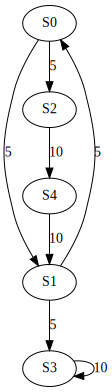

In [100]:
afficher(L)

In [106]:
L['Transitions_without_action']

{0: {'from': 'S0', 'targets': [1, 2], 'weights': [5, 5]},
 1: {'from': 'S1', 'targets': [0, 3], 'weights': [5, 5]},
 2: {'from': 'S3', 'targets': [3], 'weights': [10]},
 3: {'from': 'S2', 'targets': [4], 'weights': [10]},
 4: {'from': 'S4', 'targets': [1], 'weights': [10]}}

In [121]:
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
import numpy as np
import imageio
import os
import copy
def visu_animation(L):
  # Do not modify original data
  L_2 = copy.deepcopy(L)
  #Markov chain parameters
  states = []
  for i in range (len(L_2['States'])):
    states.append(i)
  
  for i in range (len(L_2['States'])):
      for j in range(len(L_2['Transitions_without_action'][i]['targets'])):
        L_2['Transitions_without_action'][i]['targets'][j]= int(L_2['Transitions_without_action'][i]['targets'][j][1:])
  print(L_2['Transitions_without_action'])
        

  Q = []
  for i in range (len(L_2['States'])):
    Q.append([])
    for j in range (len(L_2['States'])):
      if j not in L_2['Transitions_without_action'][i]['targets']:
        Q[i].append(0)
      else : 
        Q[i].append(L_2['Transitions_without_action'][i]['weights'][L_2['Transitions_without_action'][i]['targets'].index(j)]/sum(L_2['Transitions_without_action'][i]['weights']))


  #Sampling the markov chain over 100 steps
  N_steps=20
  node_ind=0
  node_sel=[node_ind]
  for i in range(N_steps):
    temp_ni=np.random.choice(len(states),p=Q[node_ind])
    node_sel.append(temp_ni)
    node_ind=temp_ni

  #Setting up network
  G = nx.MultiDiGraph()
  [G.add_node(s,style='filled',fillcolor='white',shape='circle',fixedsize='true',width=0.5) for s in states]

  labels={}
  edge_labels={}

  for i, origin_state in enumerate(states):
      for j, destination_state in enumerate(states):
          rate = Q[i][j]
          if rate > 0:
              G.add_edge(origin_state, destination_state, weight=rate, label="{:.02f}".format(rate),len=2)
  
  #Setting up node color for each iteration     
  for k in range(N_steps):
    for i,n in enumerate(G.nodes(data=True)):
      if i==node_sel[k]:
        n[1]['fillcolor']='blue'
      else:
        n[1]['fillcolor']='white'
      
    A = to_agraph(G)
    A.layout()
    A.draw('net_'+str(k)+'.png')

  #Create gif with imageio
  images = []
  filenames=['net_'+str(k)+'.png' for k in range(N_steps)]
  for filename in filenames:
      images.append(imageio.imread(filename))
  imageio.mimsave('markov_chain.gif', images,fps=3)
  # Delete images
  for filename in filenames:
      os.remove(filename)


In [122]:
visu_animation(L)

{0: {'from': 'S0', 'targets': [1, 2], 'weights': [5, 5]}, 1: {'from': 'S1', 'targets': [0, 3], 'weights': [5, 5]}, 2: {'from': 'S3', 'targets': [3], 'weights': [10]}, 3: {'from': 'S2', 'targets': [4], 'weights': [10]}, 4: {'from': 'S4', 'targets': [1], 'weights': [10]}}


/var/folders/zp/04t34kkj27ldhv8wcvlpqz300000gn/T/ipykernel_27328/2799415721.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [98]:
import graphviz

dot = graphviz.Digraph(comment='Processus de Décision Markoviens')

for i, state in enumerate(L['States']):
    dot.node(str(i), state)

dot.edges(['02','12'])
dot.edge('0', '1', label='test')

Utiliser la bibliothèque graphviz pour l'affichage. 
Quelques liens utiles :

Les attributs possibles pour les différentes fonctions : https://www.graphviz.org/doc/info/attrs.html

Doc graphviz : https://graphviz.readthedocs.io/en/stable/manual.html

In [99]:
print(dot.source)

// Processus de Décision Markoviens
digraph {
	0 [label=S0]
	1 [label=S1]
	2 [label=S2]
	0 -> 2
	1 -> 2
	0 -> 1 [label=test]
}



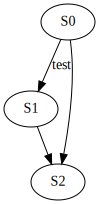

In [100]:
dot

# Calculer proba arriver dans un état final

In [130]:
def calcul_etat(L, initial_state, nb_iterations):   
    # From an initial state, calculate the probability of being in each state after nb_iterations
    # L : dictionnary of the markov chain
    # initial_state : initial state
    # nb_iterations : number of iterations
    # return : dictionnary of the probability of being in each state after nb_iterations

    # Initialisation
    states = L['States']
    transitions_without_action = L['Transitions_without_action']
    
    # Transform weights into probabilities
    for transition in transitions_without_action:
        transitions_without_action[transition]['weights'] = [weight / sum(transitions_without_action[transition]['weights']) for weight in transitions_without_action[transition]['weights']]
        

    # Probability of being in each state after nb_iterations
    proba = {}
    for state in states:
        proba[state] = 0
    proba[initial_state] = 1

    # Calculate the probability of being in each state after nb_iterations
    for i in range(nb_iterations):
        for state in states:
            proba[state] = sum([proba[transitions_without_action[transition]['from']] * transitions_without_action[transition]['weights'][i] for transition in transitions_without_action for i in range(len(transitions_without_action[transition]['targets'])) if transitions_without_action[transition]['targets'][i] == state])

    return proba
    

In [131]:
calcul_etat(L, 'S0', 50)

{'S0': 0.0, 'S1': 0.0, 'S2': 0.0, 'S3': 0.0, 'S4': 0.0}